In [46]:
import os

requirements_installed = False
max_retries = 3
retries = 0


def install_requirements():
    """Installs the requirements from requirements.txt file"""
    global requirements_installed
    if requirements_installed:
        print("Requirements already installed.")
        return

    print("Installing requirements...")
    install_status = os.system("pip install -r requirements.txt")
    if install_status == 0:
        print("Requirements installed successfully.")
        requirements_installed = True
    else:
        print("Failed to install requirements.")
        if retries < max_retries:
            print("Retrying...")
            retries += 1
            return install_requirements()
        exit(1)
    return

In [47]:
install_requirements()

Installing requirements...
Requirements installed successfully.


In [48]:
from dotenv import load_dotenv
import os


def setup_env():
    """Sets up the environment variables"""
    def check_env(env_var):
        value = os.getenv(env_var)
        if value is None:
            print(f"Please set the {env_var} environment variable.")
            exit(1)
        else:
            print(f"{env_var} is set.")
    load_dotenv()

    variables_to_check = ["GROQ_API_KEY", "OPENAI_API_KEY", "PANDASAI_API_KEY"]

    for var in variables_to_check:
        check_env(var)



In [49]:
import instructor
from groq import Groq
import traceback
from pydantic import BaseModel
from typing import Union

DEFAULT_MODEL = "llama-3.3-70b-versatile"

class LLMErrorResponse(BaseModel):
    error: str


def get_groq_client():
    """Returns an instance of the Groq class"""
    groq = Groq(api_key=os.getenv("GROQ_API_KEY"))
    client = instructor.from_groq(groq, mode=instructor.Mode.JSON)
    return client


def llm(
    prompt: str,
    response_model: BaseModel,
    system="You are a helpful AI assistant. The user will talk to you and its your job to provide detailed and clear responses.",
    model=DEFAULT_MODEL,
) -> Union[BaseModel, LLMErrorResponse]:
    """Calls LLM API with the given prompt. Defaults to llama-3.3-70b-versatile""",
    try:
        client = get_groq_client()

        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": prompt},
        ]

        response = client.chat.completions.create(
            messages=messages, model=model, response_model=response_model
        )
        return response
    except Exception as e:
        traceback.print_exc()
        return LLMErrorResponse(error=str(e))

In [50]:
setup_env()

GROQ_API_KEY is set.
OPENAI_API_KEY is set.
PANDASAI_API_KEY is set.


In [51]:
import pandas as pd
import os 
from typing import List
from pandasai import SmartDataframe, SmartDatalake
from pandasai.llm import OpenAI

class FormattedLLMResponse(BaseModel):
    response: str

class Dataset:
    """Dataset class which contains tables corresponding to CSV files in the base folder"""
    def __init__(self, database: str, tables: List[str]):
        llm = OpenAI(api_token=os.getenv("OPENAI_API_KEY"))
        if len(tables) == 0:
            raise ValueError("Tables list cannot be empty.")
        
        if not os.path.isdir(f"data/{database}"):
            raise FileNotFoundError(f"Directory {database} not found.")
        
        self.base_path = os.path.join(os.getcwd() + "/data", database)
        self.tables = {}
        self.dataframes = {}

        for table in tables:
            table_file_path = os.path.join(self.base_path, f"{table}.csv")
            if not os.path.isfile(table_file_path):
                print(f"Table file {table_file_path} not found. Skipping. ")
                continue
            df = pd.read_csv(table_file_path)
            self.tables[table] = SmartDataframe(df)
            self.dataframes[table] = pd.read_csv(table_file_path)

        print(f"Loaded {len(self.tables)} tables from {database} dataset.")

        self.datalake = SmartDatalake([self.tables[key] for key in self.tables.keys()], config={"llm": llm})

    
    def get_table(self, table_name: str) -> SmartDataframe:   
        table = self.tables.get(table_name)
        if table is None:
            raise ValueError(f"Table {table_name} not found.")
        return table 
    
    def get_datalake(self) -> SmartDatalake:
        return self.datalake
    

    def ask(self, query: str, format = "markdown") -> str:
        print("Asking...")
        datalake = self.get_datalake()
        df = datalake.chat(query)
        print("Asked.")
        df_string = ""
        if type(df) == str:
            df_string = df
        elif type(df) == pd.DataFrame:
            df_top = df.head(10)
            df_string = str(df_top)
        prompt = f"""
            Query: {query}
            Database Result: {df_string}
            Instructions:
            - Format the data and provide a human readable summary.
            - Provide insights and recommendations.
            - Don't hallucinate or make up data.
            - Provide clear, detailed and concise responses.
            f"The 'response' field should be of format = '{format}'" if format == "markdown" else ""
        """
        llm_response = llm(prompt, response_model=FormattedLLMResponse)
        return llm_response.response
    

class BooksDataset(Dataset):
    def __init__(self):
        super().__init__("books", ["books", "ratings", "users"])

class StudentPeformanceDataset(Dataset):
    def __init__(self):
        super().__init__("student_performance", ["student_performance"])

In [52]:
from IPython.display import Markdown


def render_output(markdown: str) -> None:
    """Renders the generated output file as markdown."""
    return Markdown(markdown)

In [53]:
from IPython.display import clear_output

def ask_query(query: str, dataset: Dataset) -> None:
    """Asks the given query to the dataset and returns the response."""
    response = dataset.ask(query)
    clear_output()
    response = f"### Query: {query}\n{response}"
    return render_output(response)

In [54]:
def ask_query_on_books(query: str) -> None:
    """Main function to run the script"""
    books_dataset = BooksDataset()
    return ask_query(query, books_dataset)

def ask_query_on_student_performance(query: str) -> None:
    """Main function to run the script"""
    student_performance_dataset = StudentPeformanceDataset()
    return ask_query(query, student_performance_dataset)

In [55]:
query = "What are the top 10 books with the highest average rating?"

ask_query_on_books(query)

### Query: What are the top 10 books with the highest average rating?
# No Data Available
Unfortunately, the database query returned an empty result set. There are no books with average ratings available to report.
## Recommendations:
* Check the database connection and query syntax to ensure data is being retrieved correctly.
* Verify that the database contains book rating data.
* Consider alternative data sources or APIs for book ratings.

In [56]:
query = "What are the top 10 students with the highest average grades?"

ask_query_on_student_performance(query)

### Query: What are the top 10 students with the highest average grades?
## Top 10 Students with the Highest Average Grades
The top 10 students with the highest average grades are listed below, based on the provided database result. The grades are assumed to be the average grades for each student.
### Top 10 Students:
1. **Student 556**: Grade - 91.0
2. **Student 37**: Grade - 88.0
3. **Student 925**: Grade - 80.0
4. **Student 1086**: Grade - 78.0
5. **Student 843**: Grade - 77.0
6. **Student 518**: Grade - 76.0
7. **Student 1336**: Grade - 74.0
8. **Student 823**: Grade - 73.0
9. **Student 1034**: Grade - 73.0
10. **Student 456**: Grade - 72.0
### Insights and Recommendations:
- The top 3 students have significantly higher grades than the rest, indicating a potential gap in academic performance.
- Students with higher study hours (e.g., Student 556 and Student 37) tend to have higher grades, suggesting a positive correlation between study hours and academic performance.
- However, other factors such as socioeconomic score, sleep hours, and attendance also play a role in determining academic success.

In [57]:
from pydantic import BaseModel

class BusinessReport(BaseModel):
    markdown: str

class DataAnalysisAgent:
    def __init__(self, dataset: Dataset):
        self.dataset = dataset
        self.analysis = None 
    
    def analyse(self) -> str:
        # instruction = "Respond in a human readable format. Don't provide graphs or execute code."
        analysis_questions = [
            "What are the key insights from the dataset?",
            "What are the key trends in the dataset?",
            "What are the key patterns in the dataset?",
            "What are the key anomalies in the dataset?",
            "What are the key recommendations based on the dataset?",
        ]
        self.analysis = ""
        for question in analysis_questions:
            try:
                answer = self.dataset.ask(question)
                self.analysis += f"\n### 👉🏽 {question}\n💡 {answer}"
            except Exception as e:
                print(f"Failed to ask question: {question}")
                #print(e)
                continue
        print("Preliminary analysis completed. Generating business report...")
        prompt = f"""
            Understand the provided analysis for the dataset and provide a neatly formatted report.
            This report should be professional, detailed and ideal for business stakeholders.
            The report should include all facts in the preliminary analysis and provide additional insights.
            The 'response' field should be of format = 'markdown'

            Preliminary Analysis: {self.analysis}
        """
        llm_response = llm(prompt=prompt, response_model=BusinessReport)
        if not llm_response:
            print("Failed to get response from LLM.")
            return self.analysis
        self.analysis = llm_response.markdown
        print("Business report generated.")
        return self.analysis
    
    def get_analysis(self) -> str:
        if self.analysis is None:
            return self.analyse()
        return self.analysis


In [58]:
from IPython.display import clear_output, Markdown

def data_analysis(dataset: Dataset) -> Markdown:
    agent = DataAnalysisAgent(dataset)
    analysis = agent.analyse()
    clear_output()
    return render_output(analysis)

def data_analysis_on_books() -> Markdown:
    books_dataset = BooksDataset()
    return data_analysis(books_dataset)

def data_analysis_on_student_performance() -> Markdown:
    student_performance_dataset = StudentPeformanceDataset()
    return data_analysis(student_performance_dataset)


   # Introduction
   This report provides a comprehensive analysis of a dataset related to student performance, including factors such as socioeconomic score, study hours, sleep hours, attendance, and grades. The purpose of this analysis is to identify key insights, trends, patterns, and anomalies within the dataset, and to provide recommendations for improvement.

   ## Key Insights from the Dataset
   The average socioeconomic score of the students is 0.55, indicating a moderate socioeconomic status. Students spend an average of 4.56 hours studying, sleep for 8.05 hours, and have an average attendance of 58.54%. The average grade is 40.69.

   ## Correlation with Grades
   The correlation analysis reveals that study hours have the strongest positive correlation with grades (0.810807), followed by socioeconomic score (0.335033) and attendance (0.321930). Sleep hours have a weak negative correlation with grades (-0.124689).

   ## Insights and Recommendations
   Based on the analysis, it is clear that study hours are a crucial factor in determining student grades. Therefore, it is recommended that students prioritize their study time and aim to spend more hours studying. Additionally, socioeconomic status and attendance also play a significant role in student performance, and efforts should be made to support students from disadvantaged backgrounds and encourage regular attendance.

   ## Key Trends in the Dataset
   Unfortunately, the analysis of the dataset was unsuccessful due to an error. The error message indicates that the name 'sns' is not defined, which suggests a potential issue with the code or libraries used for the analysis. To resolve this, it is recommended to check the code for any undefined variables or to ensure that all necessary libraries are properly imported.

   ## Key Patterns in the Dataset
   The dataset exhibits several key patterns, including:
   * Average Socioeconomic Score: 0.55
   * Average Study Hours: 4.56 hours
   * Average Sleep Hours: 8.05 hours
   * Average Attendance: 58.54%
   * Average Grades: 40.69
   The correlation with grades is as follows:
   * Socioeconomic Score: 0.335 (moderate positive correlation)
   * Study Hours: 0.811 (strong positive correlation)
   * Sleep Hours: -0.125 (weak negative correlation)
   * Attendance: 0.322 (moderate positive correlation)

   ## Key Anomalies in the Dataset
   The provided dataset includes socioeconomic scores, study hours, sleep hours, attendance percentages, and grades for various individuals. Key anomalies and insights from the data include:
   * **Low Attendance and High Grades**: Individual 37 has a low attendance rate of 41% but achieved a high grade of 88.
   * **High Attendance and Low Grades**: Individuals 74 and 598 have high attendance rates of 100% and 98%, respectively, but achieved relatively low grades of 58 and 58.
   * **Socioeconomic Score and Academic Performance**: There seems to be a general trend where higher socioeconomic scores correlate with higher grades, but there are exceptions.

   ## Recommendations
   Based on the insights from the data, the following recommendations can be made:
   * **Targeted Support**: Identify students with low attendance rates and provide them with targeted support to improve their academic performance.
   * **Study Habit Intervention**: For students with high attendance but low grades, interventions aimed at improving study habits could be beneficial.
   * **Socioeconomic Support**: Implement or enhance programs that provide socioeconomic support to students from lower socioeconomic backgrounds.

   # Conclusion
   This report provides a comprehensive analysis of the dataset, including key insights, trends, patterns, and anomalies. Based on the analysis, recommendations are made to support improved academic performance and create a more equitable and supportive learning environment for all students.

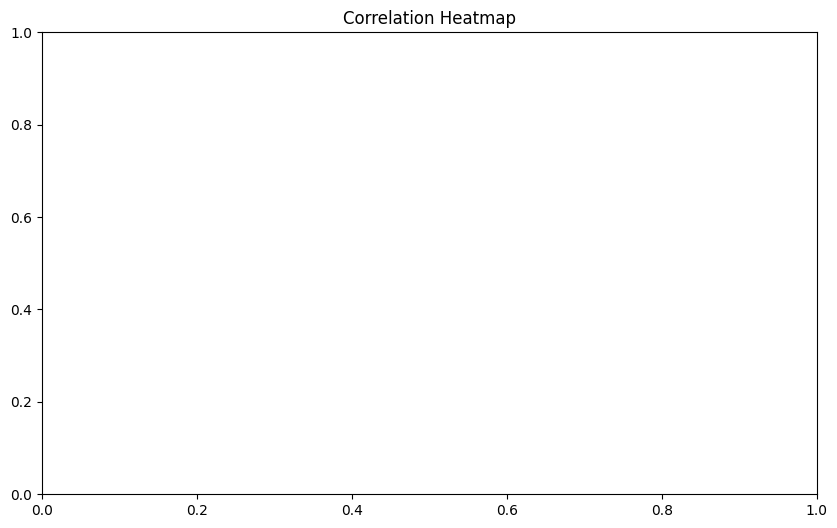

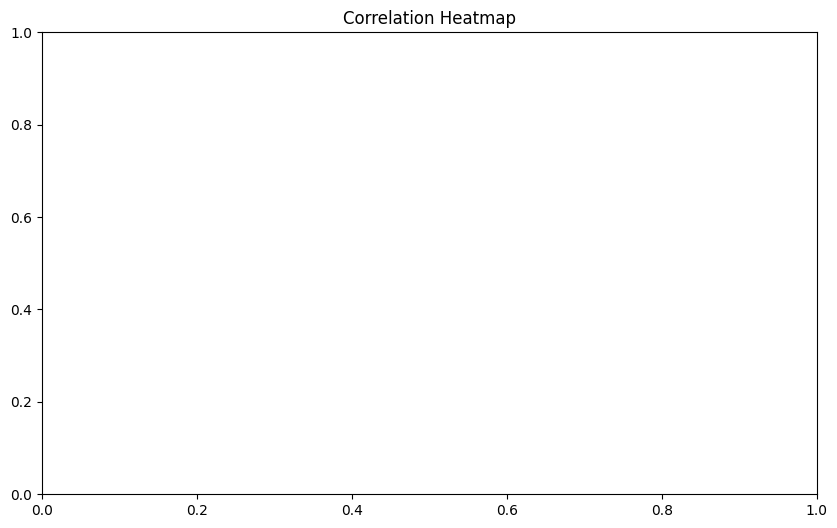

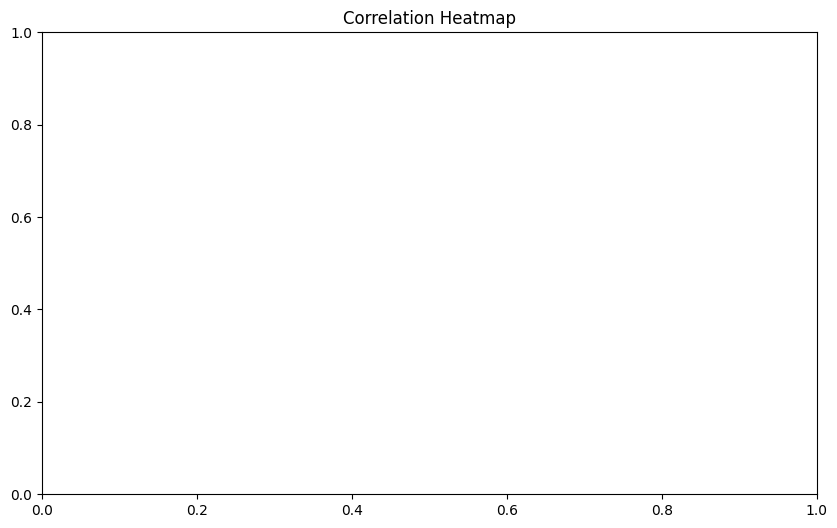

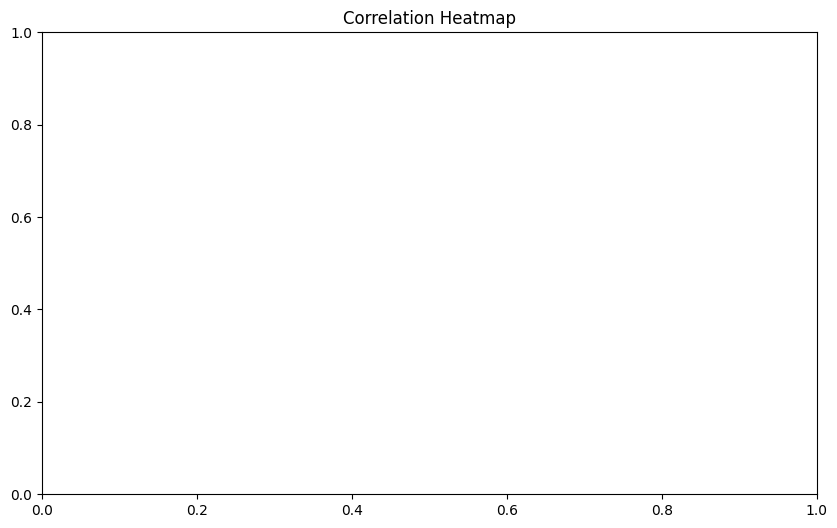

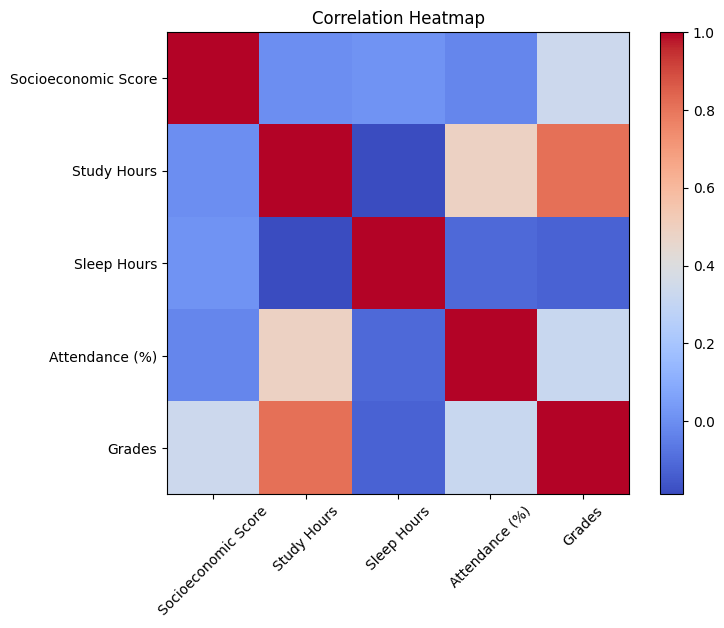

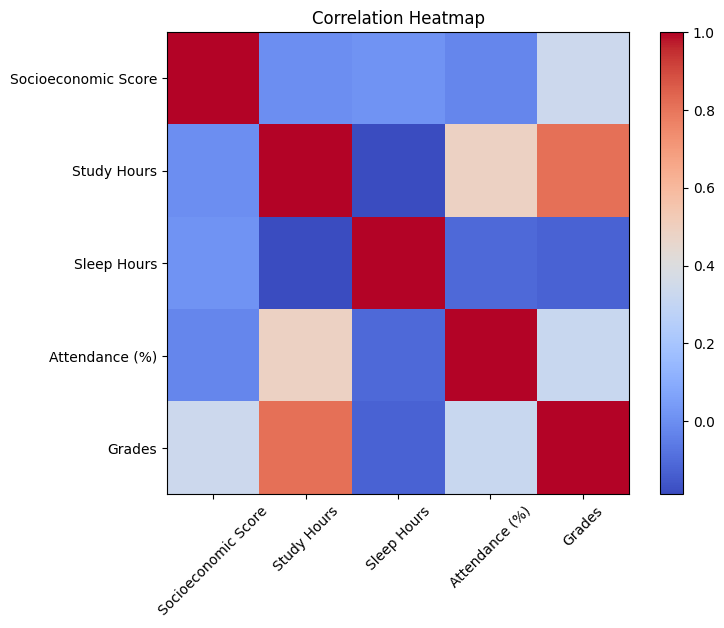

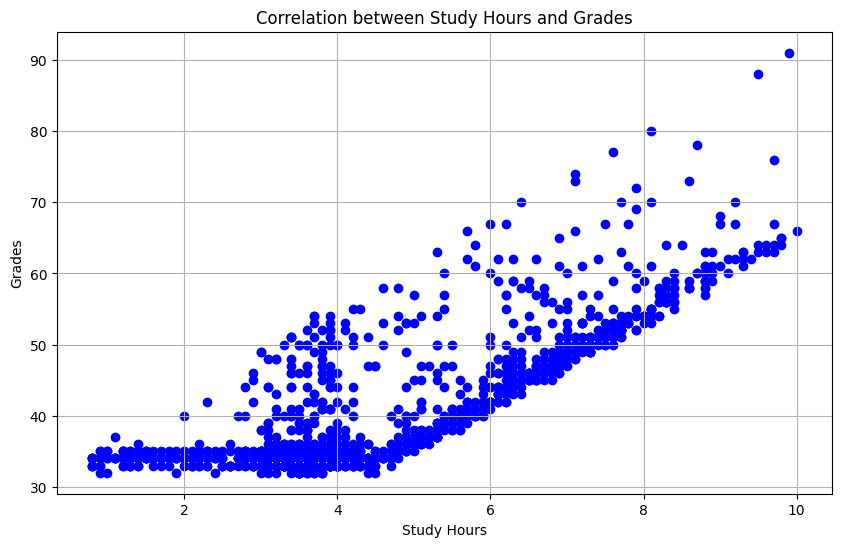

In [59]:
data_analysis_on_student_performance()